In [51]:
#!pip install matplotlib

  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached kiwisolver-1.1.0-cp37-none-win_amd64.whl (57 kB)


### Import Packages

In [1]:
import pandas as pd
from tqdm import tqdm
import unicodedata
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import ToktokTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from gensim import corpora
import gensim


import pyLDAvis
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
stemmer = SnowballStemmer("english", ignore_stopwords = True)
stopWordList=stopwords.words('english')
stopWordList.remove('no')
stopWordList.remove('not')
lemma=WordNetLemmatizer()
token=ToktokTokenizer()

In [3]:
def stopWordsRemove(text):
    wordList=[x.lower().strip() for x in token.tokenize(text)]
    removedList=[x for x in wordList if not (x in stopWordList)]
    text=' '.join(removedList)
    return text
def stemWords(text):
    wordList=[x.lower().strip() for x in token.tokenize(text)]
    stemmedlist = map(lambda x: stemmer.stem(x), wordList)
    text = ' '.join(stemmedlist)
    return text
def removeAscendingChar(data):
    data=unicodedata.normalize('NFKD',data).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return data
def removeCharDigit(text):
    stringa='`~@#$%&*()[!{”;:\’><.,/?”}]0123456789'
    text = ''.join(list(map(lambda w: ' ' if w in stringa else w, text)))
    return text

### Preprocessing

In [8]:
source_path = '../Data/'
end_path = '../Data/'
filename = 'metadata.csv'

In [9]:
df = pd.read_csv(source_path+filename)
df['key'] = df.index

In [10]:
df.columns

Index(['sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id', 'license',
       'abstract', 'publish_time', 'authors', 'journal',
       'Microsoft Academic Paper ID', 'WHO #Covidence', 'has_full_text',
       'full_text_file', 'key'],
      dtype='object')

In [11]:
papers = df[['title','abstract','key']]
papers.abstract = papers.abstract.str.replace('Abstract ','')
papers = papers.dropna(how='all',subset=['title'])
papers = papers.fillna(value=' ')
papers = papers.drop_duplicates(['title','abstract'])

C:\Users\rdemaio\AppData\Local\Continuum\anaconda3\envs\Covid-Kaggle\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [12]:
papers.info()
papers[papers.title.isnull()]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42479 entries, 0 to 44219
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     42479 non-null  object
 1   abstract  42479 non-null  object
 2   key       42479 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


,title,abstract,key


In [13]:
columns = ['title','abstract']

for column in tqdm(columns):
    papers[column] = papers[column].apply(lambda x: removeAscendingChar(x))
    papers[column] = papers[column].apply(lambda x: removeCharDigit(str(x)))
    papers[column] = papers[column].apply(lambda x: stemWords(stopWordsRemove(str(x))))
papers['text'] = papers.title + ' ' + papers.abstract

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [06:03<00:00, 181.71s/it]


In [10]:
papers.head(10)

,title,abstract,text
0,intrauterin virus infect congenit heart diseas,etiolog basi vast major case congenit heart di...,intrauterin virus infect congenit heart diseas...
1,coronavirus balkan nephriti,,coronavirus balkan nephriti
2,cigarett smoke coronari heart diseas new evid ...,,cigarett smoke coronari heart diseas new evid ...
3,clinic immunolog studi ident twin discord syst...,middle-ag femal ident twin one system lupus er...,clinic immunolog studi ident twin discord syst...
4,epidemiolog community-acquir respiratori tract...,upper respiratori tract infect common type inf...,epidemiolog community-acquir respiratori tract...
5,infecti diarrhea pathogenesi risk factor,understand pathogenesi infecti especi bacteri ...,infecti diarrhea pathogenesi risk factor under...
6,new perspect pathogenesi rheumatoid arthriti,pathogenesi rheumatoid arthriti local produc a...,new perspect pathogenesi rheumatoid arthriti p...
7,manag acut chronic respiratori tract infect,pharyng bronchiti pneumonia repres common resp...,manag acut chronic respiratori tract infect ph...
8,acut bronchiti result u european trial antibio...,acut bronchiti ill frequent encount primary-ca...,acut bronchiti result u european trial antibio...
9,clinic immunolog respons patient viral keratoc...,,clinic immunolog respons patient viral keratoc...


### Store Processed Text

In [3]:
papers.to_csv(end_path + 'papers_text.csv', header = True)

NameError: name 'papers' is not defined

### Retrieve Data

In [4]:
end_path = '../Data/'
papers = pd.read_csv(end_path + 'papers_text.csv', index_col = 0)
papers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42479 entries, 0 to 44219
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     42476 non-null  object
 1   abstract  35282 non-null  object
 2   text      42479 non-null  object
dtypes: object(3)
memory usage: 1.3+ MB


### Build Corpus

In [14]:
def build_corpus(df,column):
    corpus = []
    for data in tqdm(df[column].dropna()):
        words = [x for x in token.tokenize(data) if not (x in stopWordList)]
        words = [lemma.lemmatize(x) for x in words if len(x) > 2 ]
        corpus.append(words)
    return corpus   

In [15]:
def prepare_text(text):
    words = [x for x in token.tokenize(removeAscendingChar(str(text))) if not (x in stopWordList)]
    words = [lemma.lemmatize(x) for x in words if len(x) > 2 ]
    return words

In [16]:
#title_corpus = build_corpus(papers,'title')
#abstract_corpus = build_corpus(papers,'abstract')
text_corpus = build_corpus(papers,'text')

100%|███████████████████████████████████████████████████████████████████████████| 42479/42479 [02:08<00:00, 331.70it/s]


In [17]:
dictionary = corpora.Dictionary(text_corpus)
dictionary.filter_extremes(no_below = 3, no_above = 0.99)
dictionary.save('../Model/dictionary')

In [18]:
corpus = [dictionary.doc2bow(text) for text in text_corpus]

In [19]:
papers = pd.concat([papers,pd.Series(text_corpus,name = 'text_corpus')], axis = 1)

### Optimizing the number of Topics

In [20]:
from gensim.models import CoherenceModel,LdaModel,HdpModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [21]:
def get_best_model(models, score_list, numbers):
    m = max(score_list)
    k = min([i for i,j in enumerate(score_list) if j==m])
    print("The best model is number:", k)
    return numbers[k],models[k]

100%|█████████████████████████████████████████████████████████████████████████████████| 5/5 [-1:18:18<00:00, -0.00it/s]


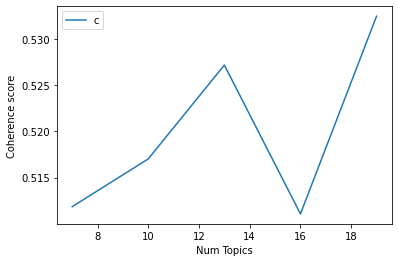

Num Topics = 7  has Coherence Value of 0.5119
Num Topics = 10  has Coherence Value of 0.517
Num Topics = 13  has Coherence Value of 0.5272
Num Topics = 16  has Coherence Value of 0.5111
Num Topics = 19  has Coherence Value of 0.5324


In [22]:
LIMIT_NUM = 20
STEP_NUM = 3
START_NUM = 7
model_list, coherence_values = compute_coherence_values(dictionary=dictionary,
                                                        corpus=corpus,
                                                        texts=papers['text_corpus'].fillna(''), 
                                                        start=START_NUM, 
                                                        limit=LIMIT_NUM, 
                                                        step=STEP_NUM)
# Show graph
limit=LIMIT_NUM; start=START_NUM; step=STEP_NUM;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [23]:
num_topics, lda_model = get_best_model(model_list, coherence_values,x)
lda_model.save('../Model/lda.model')

The best model is number: 4


#### Get Topics

In [73]:
NUM_WORDS = 7
topics = lda_model.print_topics(num_words =NUM_WORDS)
topics

[(0,
  '0.046*"cell" + 0.022*"virus" + 0.020*"not" + 0.018*"activ" + 0.017*"process" + 0.017*"antigen" + 0.016*"antibodi"'),
 (1,
  '0.031*"diseas" + 0.029*"stimul" + 0.024*"absorpt" + 0.022*"famili" + 0.022*"crohn" + 0.018*"jejunum" + 0.018*"similar"'),
 (2,
  '0.059*"inhibit" + 0.042*"cell" + 0.041*"activ" + 0.027*"inhibitor" + 0.026*"concentr" + 0.023*"effect" + 0.021*"synthesi"'),
 (3,
  '0.038*"infect" + 0.031*"virus" + 0.025*"day" + 0.020*"activ" + 0.019*"absorpt" + 0.018*"model" + 0.016*"complex"'),
 (4,
  '0.063*"cell" + 0.038*"express" + 0.028*"antigen" + 0.026*"microglia" + 0.020*"viral" + 0.017*"virus" + 0.016*"rat"'),
 (5,
  '0.048*"virus" + 0.023*"diseas" + 0.020*"activ" + 0.020*"infect" + 0.014*"pig" + 0.014*"isol" + 0.013*"anim"'),
 (6,
  '0.044*"infect" + 0.035*"pneumonia" + 0.028*"agent" + 0.027*"adult" + 0.024*"viral" + 0.022*"year" + 0.022*"pathogen"'),
 (7,
  '0.025*"refer" + 0.022*"author" + 0.021*"format" + 0.021*"electron" + 0.020*"review" + 0.018*"includ" + 0.01

In [44]:
test_text = 'A new method to find coronavirus pathogene by protein test'
test_text = prepare_text(test_text)
other_corpus_text = dictionary.doc2bow(test_text)
lda_model[other_corpus_text]

[(20, 0.25199482), (41, 0.6117876)]

### LDA Visualization

In [62]:
from pyLDAvis import gensim
lda_display = gensim.prepare(ldamodel3, corpus, dictionary, sort_topics=False)
pyLDAvis.show(lda_display)

TypeError: Object of type complex is not JSON serializable

### Generate Topics features

In [27]:
def topics_sentences(model, corpus, dataset):
    """
   Function to get:
   - percentage per topic for every document in texts
   - dominant topic 
   - keywords 
    """
    contents = dataset[['title','text_corpus','key']]
    df = pd.DataFrame()
    topics_text = model[corpus]
    for i,row in tqdm(enumerate(topics_text)):
        row = sorted(row, key = lambda x: x[1], reverse = True)
        for j, (topic_num, prob_topic) in enumerate(row):
            if j==0:
                wp = model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                df = df.append(
                    pd.Series([int(topic_num),round(prob_topic,4),topic_keywords]),
                    ignore_index = True)
            else:
                break
    df = pd.concat([df, contents], axis = 1).reset_index()
    df.columns = ['Document_Number','Dominant_Topic','Perc_Contribution', 'Topic_Keywords','title', 'text','key']
    df.info()
    return df

In [28]:
topic_per_document = topics_sentences(lda_model, corpus, papers)


0it [00:00, ?it/s]
7it [00:00, 63.12it/s]
15it [00:00, 65.20it/s]
21it [00:00, 62.00it/s]
28it [00:00, 63.57it/s]
33it [00:00, 55.66it/s]
39it [00:00, 53.94it/s]
44it [00:00, 51.04it/s]
52it [00:00, 55.67it/s]
58it [00:01, 52.89it/s]
64it [00:01, 51.95it/s]
70it [00:01, 50.97it/s]
76it [00:01, 53.35it/s]
83it [00:01, 57.37it/s]
89it [00:01, 53.92it/s]
97it [00:01, 58.76it/s]
105it [00:01, 62.03it/s]
112it [00:01, 58.56it/s]
119it [00:02, 56.46it/s]
125it [00:02, 54.32it/s]
132it [00:02, 57.64it/s]
138it [00:02, 50.76it/s]
145it [00:02, 54.44it/s]
153it [00:02, 59.05it/s]
160it [00:02, 58.13it/s]
167it [00:02, 59.66it/s]
174it [00:03, 57.55it/s]
180it [00:03, 57.12it/s]
188it [00:03, 60.99it/s]
195it [00:03, 60.54it/s]
202it [00:03, 61.93it/s]
210it [00:03, 64.55it/s]
218it [00:03, 67.00it/s]
225it [00:03, 64.10it/s]
232it [00:03, 64.81it/s]
239it [00:04, 59.12it/s]
246it [00:04, 55.54it/s]
252it [00:04, 53.80it/s]
259it [00:04, 56.81it/s]
266it [00:04, 59.60it/s]
273it [00:04, 58.66it

3685it [01:06, 56.63it/s]
3691it [01:06, 56.98it/s]
3697it [01:06, 56.91it/s]
3703it [01:06, 56.45it/s]
3709it [01:06, 55.21it/s]
3715it [01:06, 53.78it/s]
3721it [01:06, 55.02it/s]
3727it [01:06, 54.97it/s]
3733it [01:07, 51.46it/s]
3739it [01:07, 51.44it/s]
3745it [01:07, 53.64it/s]
3751it [01:07, 53.52it/s]
3757it [01:07, 52.73it/s]
3763it [01:07, 51.25it/s]
3769it [01:07, 51.30it/s]
3775it [01:07, 45.93it/s]
3782it [01:08, 49.98it/s]
3789it [01:08, 53.57it/s]
3796it [01:08, 56.30it/s]
3803it [01:08, 58.78it/s]
3810it [01:08, 57.48it/s]
3816it [01:08, 55.67it/s]
3822it [01:08, 53.38it/s]
3828it [01:08, 53.19it/s]
3834it [01:08, 53.53it/s]
3840it [01:09, 54.65it/s]
3846it [01:09, 54.03it/s]
3852it [01:09, 53.53it/s]
3858it [01:09, 54.38it/s]
3864it [01:09, 54.77it/s]
3870it [01:09, 55.11it/s]
3876it [01:09, 51.75it/s]
3882it [01:09, 51.60it/s]
3888it [01:09, 53.75it/s]
3895it [01:10, 55.94it/s]
3901it [01:10, 56.88it/s]
3908it [01:10, 58.93it/s]
3914it [01:10, 58.95it/s]
3920it [01:1

7116it [02:11, 52.47it/s]
7122it [02:11, 50.25it/s]
7128it [02:11, 49.41it/s]
7134it [02:11, 49.75it/s]
7140it [02:11, 50.24it/s]
7146it [02:11, 51.14it/s]
7152it [02:12, 52.08it/s]
7158it [02:12, 53.78it/s]
7165it [02:12, 56.36it/s]
7171it [02:12, 56.01it/s]
7177it [02:12, 54.81it/s]
7183it [02:12, 53.42it/s]
7189it [02:12, 53.84it/s]
7195it [02:12, 52.44it/s]
7201it [02:12, 51.59it/s]
7207it [02:13, 51.72it/s]
7213it [02:13, 52.23it/s]
7219it [02:13, 50.91it/s]
7225it [02:13, 51.28it/s]
7231it [02:13, 51.25it/s]
7237it [02:13, 49.96it/s]
7243it [02:13, 50.04it/s]
7249it [02:13, 50.20it/s]
7255it [02:14, 51.74it/s]
7261it [02:14, 52.88it/s]
7267it [02:14, 54.69it/s]
7273it [02:14, 55.91it/s]
7279it [02:14, 55.23it/s]
7285it [02:14, 56.40it/s]
7291it [02:14, 53.53it/s]
7297it [02:14, 54.04it/s]
7303it [02:14, 53.23it/s]
7309it [02:15, 52.52it/s]
7315it [02:15, 52.28it/s]
7321it [02:15, 52.01it/s]
7327it [02:15, 50.91it/s]
7333it [02:15, 50.50it/s]
7339it [02:15, 51.96it/s]
7345it [02:1

10506it [03:16, 53.70it/s]
10512it [03:16, 52.71it/s]
10518it [03:16, 53.87it/s]
10524it [03:16, 53.96it/s]
10530it [03:17, 53.38it/s]
10536it [03:17, 51.29it/s]
10542it [03:17, 50.72it/s]
10548it [03:17, 51.15it/s]
10554it [03:17, 50.92it/s]
10560it [03:17, 50.67it/s]
10566it [03:17, 49.75it/s]
10571it [03:17, 49.31it/s]
10577it [03:17, 50.61it/s]
10583it [03:18, 52.59it/s]
10589it [03:18, 47.41it/s]
10595it [03:18, 48.54it/s]
10601it [03:18, 49.74it/s]
10607it [03:18, 49.98it/s]
10613it [03:18, 50.25it/s]
10619it [03:18, 50.79it/s]
10625it [03:18, 51.50it/s]
10631it [03:19, 52.20it/s]
10637it [03:19, 53.58it/s]
10643it [03:19, 52.91it/s]
10649it [03:19, 52.32it/s]
10655it [03:19, 50.53it/s]
10661it [03:19, 49.47it/s]
10666it [03:19, 47.90it/s]
10671it [03:19, 46.27it/s]
10678it [03:19, 49.85it/s]
10684it [03:20, 48.77it/s]
10689it [03:20, 49.03it/s]
10695it [03:20, 51.51it/s]
10701it [03:20, 51.30it/s]
10707it [03:20, 51.15it/s]
10713it [03:20, 51.07it/s]
10719it [03:20, 51.24it/s]
1

13980it [04:19, 51.39it/s]
13986it [04:20, 52.90it/s]
13992it [04:20, 53.56it/s]
13998it [04:20, 53.40it/s]
14004it [04:20, 51.11it/s]
14010it [04:20, 51.13it/s]
14016it [04:20, 50.76it/s]
14022it [04:20, 50.95it/s]
14028it [04:20, 51.82it/s]
14034it [04:21, 52.94it/s]
14040it [04:21, 51.53it/s]
14046it [04:21, 50.52it/s]
14052it [04:21, 50.92it/s]
14058it [04:21, 53.09it/s]
14064it [04:21, 52.43it/s]
14070it [04:21, 52.24it/s]
14076it [04:21, 52.20it/s]
14082it [04:21, 46.38it/s]
14088it [04:22, 49.55it/s]
14095it [04:22, 52.51it/s]
14101it [04:22, 51.66it/s]
14107it [04:22, 49.54it/s]
14113it [04:22, 47.97it/s]
14118it [04:22, 48.53it/s]
14124it [04:22, 49.35it/s]
14130it [04:22, 50.17it/s]
14136it [04:23, 49.91it/s]
14142it [04:23, 48.89it/s]
14147it [04:23, 48.96it/s]
14153it [04:23, 49.55it/s]
14158it [04:23, 49.57it/s]
14164it [04:23, 50.71it/s]
14171it [04:23, 54.42it/s]
14177it [04:23, 53.58it/s]
14183it [04:23, 53.91it/s]
14191it [04:24, 57.85it/s]
14198it [04:24, 58.92it/s]
1

17243it [05:23, 56.35it/s]
17249it [05:23, 53.11it/s]
17255it [05:23, 52.03it/s]
17261it [05:23, 52.47it/s]
17267it [05:23, 52.64it/s]
17273it [05:24, 50.53it/s]
17279it [05:24, 52.87it/s]
17286it [05:24, 56.31it/s]
17292it [05:24, 55.39it/s]
17298it [05:24, 55.11it/s]
17304it [05:24, 54.29it/s]
17310it [05:24, 55.01it/s]
17316it [05:24, 53.01it/s]
17322it [05:24, 52.04it/s]
17328it [05:25, 51.39it/s]
17334it [05:25, 51.67it/s]
17340it [05:25, 51.81it/s]
17346it [05:25, 51.39it/s]
17352it [05:25, 51.14it/s]
17358it [05:25, 51.39it/s]
17364it [05:25, 52.12it/s]
17370it [05:25, 51.07it/s]
17376it [05:25, 49.95it/s]
17382it [05:26, 49.88it/s]
17390it [05:26, 55.10it/s]
17396it [05:26, 55.14it/s]
17402it [05:26, 54.13it/s]
17408it [05:26, 53.28it/s]
17414it [05:26, 52.70it/s]
17420it [05:26, 52.27it/s]
17426it [05:26, 52.41it/s]
17432it [05:27, 50.46it/s]
17438it [05:27, 50.01it/s]
17444it [05:27, 51.19it/s]
17450it [05:27, 52.74it/s]
17456it [05:27, 52.20it/s]
17462it [05:27, 51.10it/s]
1

20428it [06:26, 50.87it/s]
20434it [06:26, 53.20it/s]
20440it [06:26, 51.92it/s]
20446it [06:26, 51.89it/s]
20452it [06:27, 49.69it/s]
20458it [06:27, 47.39it/s]
20464it [06:27, 49.17it/s]
20470it [06:27, 50.12it/s]
20476it [06:27, 50.06it/s]
20482it [06:27, 48.33it/s]
20487it [06:27, 38.57it/s]
20493it [06:27, 43.04it/s]
20500it [06:28, 47.99it/s]
20506it [06:28, 50.19it/s]
20512it [06:28, 51.73it/s]
20518it [06:28, 52.18it/s]
20525it [06:28, 54.29it/s]
20531it [06:28, 50.80it/s]
20537it [06:28, 50.60it/s]
20543it [06:28, 51.03it/s]
20549it [06:29, 51.24it/s]
20555it [06:29, 50.99it/s]
20561it [06:29, 51.10it/s]
20567it [06:29, 49.84it/s]
20573it [06:29, 49.90it/s]
20579it [06:29, 46.13it/s]
20585it [06:29, 48.40it/s]
20590it [06:29, 47.44it/s]
20596it [06:29, 48.05it/s]
20601it [06:30, 47.74it/s]
20607it [06:30, 50.35it/s]
20613it [06:30, 51.40it/s]
20619it [06:30, 50.36it/s]
20626it [06:30, 52.52it/s]
20632it [06:30, 51.56it/s]
20638it [06:30, 51.64it/s]
20644it [06:30, 49.29it/s]
2

23547it [07:29, 51.96it/s]
23553it [07:30, 50.11it/s]
23559it [07:30, 50.88it/s]
23565it [07:30, 51.30it/s]
23571it [07:30, 50.81it/s]
23577it [07:30, 43.83it/s]
23582it [07:30, 44.61it/s]
23587it [07:30, 44.89it/s]
23592it [07:30, 45.98it/s]
23597it [07:30, 46.49it/s]
23602it [07:31, 45.69it/s]
23608it [07:31, 47.25it/s]
23613it [07:31, 47.76it/s]
23619it [07:31, 48.89it/s]
23625it [07:31, 49.68it/s]
23630it [07:31, 48.87it/s]
23635it [07:31, 48.29it/s]
23640it [07:31, 47.99it/s]
23646it [07:31, 49.30it/s]
23652it [07:32, 50.31it/s]
23658it [07:32, 51.79it/s]
23664it [07:32, 52.59it/s]
23670it [07:32, 51.91it/s]
23676it [07:32, 51.57it/s]
23682it [07:32, 50.20it/s]
23688it [07:32, 49.65it/s]
23693it [07:32, 49.19it/s]
23698it [07:32, 49.27it/s]
23703it [07:33, 45.60it/s]
23708it [07:33, 46.19it/s]
23713it [07:33, 45.84it/s]
23718it [07:33, 44.16it/s]
23723it [07:33, 44.98it/s]
23729it [07:33, 46.86it/s]
23734it [07:33, 47.27it/s]
23739it [07:33, 47.68it/s]
23744it [07:33, 47.36it/s]
2

26694it [08:33, 50.04it/s]
26700it [08:33, 50.06it/s]
26706it [08:33, 50.56it/s]
26712it [08:33, 50.87it/s]
26718it [08:33, 51.22it/s]
26724it [08:33, 51.67it/s]
26730it [08:34, 52.27it/s]
26736it [08:34, 53.81it/s]
26742it [08:34, 53.28it/s]
26748it [08:34, 50.67it/s]
26754it [08:34, 50.01it/s]
26760it [08:34, 48.24it/s]
26765it [08:34, 48.69it/s]
26770it [08:34, 48.40it/s]
26776it [08:35, 49.75it/s]
26781it [08:35, 48.48it/s]
26787it [08:35, 50.17it/s]
26793it [08:35, 51.08it/s]
26799it [08:35, 51.48it/s]
26805it [08:35, 51.52it/s]
26811it [08:35, 51.06it/s]
26817it [08:35, 49.91it/s]
26823it [08:35, 49.68it/s]
26829it [08:36, 50.63it/s]
26835it [08:36, 52.87it/s]
26841it [08:36, 53.17it/s]
26847it [08:36, 51.78it/s]
26853it [08:36, 51.12it/s]
26859it [08:36, 51.79it/s]
26865it [08:36, 51.59it/s]
26871it [08:36, 49.80it/s]
26877it [08:36, 50.15it/s]
26883it [08:37, 50.14it/s]
26889it [08:37, 50.37it/s]
26895it [08:37, 49.58it/s]
26900it [08:37, 49.18it/s]
26905it [08:37, 46.67it/s]
2

30058it [09:36, 47.01it/s]
30065it [09:36, 50.16it/s]
30071it [09:37, 48.71it/s]
30077it [09:37, 49.24it/s]
30083it [09:37, 48.38it/s]
30088it [09:37, 48.18it/s]
30093it [09:37, 48.68it/s]
30098it [09:37, 47.96it/s]
30103it [09:37, 47.67it/s]
30108it [09:37, 46.45it/s]
30113it [09:37, 46.49it/s]
30119it [09:38, 48.83it/s]
30125it [09:38, 51.62it/s]
30131it [09:38, 49.26it/s]
30136it [09:38, 47.70it/s]
30141it [09:38, 47.78it/s]
30146it [09:38, 48.04it/s]
30151it [09:38, 46.92it/s]
30156it [09:38, 46.92it/s]
30162it [09:38, 47.95it/s]
30167it [09:39, 43.63it/s]
30173it [09:39, 46.67it/s]
30178it [09:39, 47.23it/s]
30184it [09:39, 50.31it/s]
30191it [09:39, 54.03it/s]
30197it [09:39, 52.03it/s]
30203it [09:39, 52.44it/s]
30209it [09:39, 51.65it/s]
30215it [09:39, 50.79it/s]
30221it [09:40, 50.59it/s]
30227it [09:40, 48.97it/s]
30232it [09:40, 48.52it/s]
30237it [09:40, 48.71it/s]
30242it [09:40, 47.57it/s]
30247it [09:40, 45.52it/s]
30252it [09:40, 46.66it/s]
30258it [09:40, 47.83it/s]
3

33084it [10:39, 48.57it/s]
33090it [10:39, 49.06it/s]
33096it [10:39, 49.55it/s]
33101it [10:39, 49.14it/s]
33106it [10:39, 48.50it/s]
33111it [10:39, 47.64it/s]
33116it [10:39, 47.39it/s]
33122it [10:40, 49.10it/s]
33128it [10:40, 50.25it/s]
33134it [10:40, 51.29it/s]
33140it [10:40, 51.64it/s]
33146it [10:40, 49.71it/s]
33151it [10:40, 49.67it/s]
33156it [10:40, 47.47it/s]
33161it [10:40, 45.91it/s]
33167it [10:40, 47.49it/s]
33172it [10:41, 46.94it/s]
33177it [10:41, 45.04it/s]
33182it [10:41, 45.57it/s]
33188it [10:41, 48.30it/s]
33193it [10:41, 48.53it/s]
33198it [10:41, 48.42it/s]
33203it [10:41, 42.66it/s]
33208it [10:41, 43.65it/s]
33213it [10:42, 42.29it/s]
33218it [10:42, 44.02it/s]
33224it [10:42, 46.99it/s]
33229it [10:42, 47.73it/s]
33235it [10:42, 48.49it/s]
33241it [10:42, 49.13it/s]
33247it [10:42, 48.72it/s]
33252it [10:42, 47.55it/s]
33257it [10:42, 47.99it/s]
33262it [10:43, 47.07it/s]
33267it [10:43, 42.52it/s]
33272it [10:43, 42.96it/s]
33277it [10:43, 44.08it/s]
3

36057it [11:40, 49.09it/s]
36062it [11:41, 42.85it/s]
36067it [11:41, 42.82it/s]
36073it [11:41, 46.57it/s]
36079it [11:41, 49.37it/s]
36085it [11:41, 50.80it/s]
36091it [11:41, 53.12it/s]
36098it [11:41, 56.22it/s]
36104it [11:41, 53.65it/s]
36110it [11:42, 52.53it/s]
36117it [11:42, 55.89it/s]
36123it [11:42, 56.94it/s]
36129it [11:42, 55.59it/s]
36135it [11:42, 54.04it/s]
36141it [11:42, 47.86it/s]
36146it [11:42, 47.51it/s]
36151it [11:42, 46.31it/s]
36156it [11:42, 47.30it/s]
36161it [11:43, 47.03it/s]
36166it [11:43, 46.83it/s]
36171it [11:43, 46.83it/s]
36176it [11:43, 47.30it/s]
36181it [11:43, 47.16it/s]
36186it [11:43, 47.50it/s]
36191it [11:43, 47.88it/s]
36196it [11:43, 46.74it/s]
36202it [11:43, 48.16it/s]
36207it [11:44, 46.92it/s]
36212it [11:44, 45.75it/s]
36218it [11:44, 48.51it/s]
36224it [11:44, 49.62it/s]
36230it [11:44, 48.55it/s]
36235it [11:44, 48.37it/s]
36240it [11:44, 48.11it/s]
36245it [11:44, 46.79it/s]
36250it [11:44, 45.04it/s]
36256it [11:45, 47.61it/s]
3

39053it [12:43, 51.51it/s]
39059it [12:43, 51.07it/s]
39065it [12:43, 50.35it/s]
39071it [12:43, 49.78it/s]
39077it [12:43, 48.35it/s]
39082it [12:43, 48.14it/s]
39087it [12:43, 48.57it/s]
39092it [12:43, 47.73it/s]
39097it [12:44, 48.20it/s]
39102it [12:44, 48.62it/s]
39108it [12:44, 49.85it/s]
39114it [12:44, 49.74it/s]
39119it [12:44, 47.09it/s]
39124it [12:44, 45.88it/s]
39130it [12:44, 47.19it/s]
39135it [12:44, 47.83it/s]
39140it [12:44, 47.39it/s]
39145it [12:45, 47.35it/s]
39150it [12:45, 46.68it/s]
39155it [12:45, 45.70it/s]
39160it [12:45, 45.98it/s]
39165it [12:45, 46.74it/s]
39170it [12:45, 45.60it/s]
39175it [12:45, 46.78it/s]
39180it [12:45, 46.15it/s]
39185it [12:45, 46.85it/s]
39190it [12:45, 47.52it/s]
39196it [12:46, 48.79it/s]
39202it [12:46, 50.71it/s]
39208it [12:46, 50.65it/s]
39214it [12:46, 49.47it/s]
39219it [12:46, 46.44it/s]
39224it [12:46, 46.18it/s]
39229it [12:46, 46.76it/s]
39234it [12:46, 41.73it/s]
39241it [12:47, 46.07it/s]
39246it [12:47, 42.26it/s]
3

42012it [13:44, 48.07it/s]
42017it [13:45, 46.77it/s]
42022it [13:45, 47.32it/s]
42027it [13:45, 47.05it/s]
42032it [13:45, 47.29it/s]
42037it [13:45, 47.11it/s]
42042it [13:45, 46.10it/s]
42047it [13:45, 46.56it/s]
42053it [13:45, 48.00it/s]
42058it [13:45, 48.17it/s]
42064it [13:46, 49.79it/s]
42070it [13:46, 48.86it/s]
42075it [13:46, 48.77it/s]
42080it [13:46, 48.59it/s]
42085it [13:46, 48.69it/s]
42090it [13:46, 47.81it/s]
42095it [13:46, 47.48it/s]
42100it [13:46, 46.99it/s]
42105it [13:46, 47.59it/s]
42110it [13:47, 47.61it/s]
42115it [13:47, 46.07it/s]
42120it [13:47, 41.04it/s]
42125it [13:47, 40.93it/s]
42131it [13:47, 43.43it/s]
42136it [13:47, 44.33it/s]
42141it [13:47, 34.49it/s]
42145it [13:48, 31.54it/s]
42149it [13:48, 29.18it/s]
42154it [13:48, 32.53it/s]
42158it [13:48, 34.09it/s]
42163it [13:48, 36.39it/s]
42169it [13:48, 40.32it/s]
42175it [13:48, 43.36it/s]
42180it [13:48, 43.38it/s]
42186it [13:48, 45.62it/s]
42191it [13:49, 45.87it/s]
42197it [13:49, 47.82it/s]
4

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44217 entries, 0 to 44216
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Document_Number    44217 non-null  int64  
 1   Dominant_Topic     42479 non-null  float64
 2   Perc_Contribution  42479 non-null  float64
 3   Topic_Keywords     42479 non-null  object 
 4   title              42479 non-null  object 
 5   text               42479 non-null  object 
 6   key                42479 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 2.4+ MB


In [29]:
topic_per_document.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44217 entries, 0 to 44216
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Document_Number    44217 non-null  int64  
 1   Dominant_Topic     42479 non-null  float64
 2   Perc_Contribution  42479 non-null  float64
 3   Topic_Keywords     42479 non-null  object 
 4   title              42479 non-null  object 
 5   text               42479 non-null  object 
 6   key                42479 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 2.4+ MB


In [30]:
topic_per_document.to_csv(end_path+'topic_per_document.csv',header = True)

In [31]:
topic_per_document.sort_values(['Dominant_Topic','Perc_Contribution'],ascending = [True,False]).groupby(['Dominant_Topic']).head(1)

,Document_Number,Dominant_Topic,Perc_Contribution,Topic_Keywords,title,text,key
139,139,0.0,0.9938,"rna, protein, sequenc, coronavirus, genom, vir...",mutat analysi rna pseudoknot compon coronaviru...,"[mutat, analysi, rna, pseudoknot, compon, coro...",139.0
13460,13460,1.0,0.8420,"reproduct, prrsv, astrovirus, lectin, equin, r...",microorganism-ion respir reduc breath resist s...,"[gastrointestin, diseas, guinea, pig, rabbit]",13460.0
14307,14307,2.0,0.9861,"use, virus, method, result, studi, effect, con...",sars-coronavirus sars-cov safeti solvent deter...,"[ultrasound-assist, extract, five, isoflavon, ...",14307.0
11609,11609,3.0,0.8647,"calv, rotavirus, bovin, diarrhea, intestin, co...",traf signal competit bind evolv adapt viral mo...,"[biosecur, gastrointestin, diseas, adult, dair...",11609.0
21591,21591,4.0,0.9814,"virus, host, viral, immun, infect, respons, hu...",effici generat recombin rna virus use target r...,"[cytosol, innat, immun, sen, signal, upon, inf...",21591.0
10194,10194,5.0,0.8947,"china, citi, provinc, chine, health, particip,...",efficaci ethanol virus hand disinfect,"[five, question, critic, care, educ, ask, simu...",10194.0
1738,1738,6.0,0.9690,"use, drug, antivir, activ, target, develop, co...",enceph viral,"[phytochem, biolog, research, polygonea, medic...",1738.0
2650,2650,7.0,0.9877,"diseas, health, outbreak, emerg, transmiss, pu...",chapter respiratori viral vaccin,"[chapter, histori, disast, epidemiolog, disast...",2650.0
2848,2848,8.0,0.8413,"hospit, care, patient, quarantin, ventil, use,...",laboratori biosecur unit state evolut regul,"[chapter, bioterror, intens, care, unit]",2848.0
7737,7737,9.0,0.9915,"detect, virus, respiratori, test, sampl, assay...",evolut china ' respons hiv aid,"[improv, detect, human, influenza, virus, resp...",7737.0


In [32]:
def get_topic_distribution(model, corpus):
    columns = ['Topic_no_'+str(x) for x in range(0,num_topics)]
    topic_distr_docs = pd.DataFrame()
    for i,document in tqdm(enumerate(corpus)):
        topic_distr_docs = topic_distr_docs.append(pd.Series(list(list(
            zip(*model.get_document_topics(document, minimum_probability=0)))[1])
                                                             ,dtype = 'float64'),
                                                   ignore_index = True
                                                  )
    topic_distr_docs.columns=columns
    return topic_distr_docs

In [33]:
topic_distr_docs = get_topic_distribution(lda_model, corpus)


0it [00:00, ?it/s]
13it [00:00, 127.60it/s]
25it [00:00, 125.12it/s]
42it [00:00, 134.59it/s]
60it [00:00, 143.77it/s]
74it [00:00, 138.89it/s]
89it [00:00, 138.58it/s]
102it [00:00, 135.56it/s]
115it [00:00, 127.47it/s]
133it [00:00, 137.97it/s]
149it [00:01, 143.34it/s]
164it [00:01, 142.09it/s]
179it [00:01, 133.70it/s]
193it [00:01, 124.08it/s]
206it [00:01, 123.70it/s]
222it [00:01, 131.40it/s]
236it [00:01, 126.66it/s]
249it [00:01, 122.91it/s]
265it [00:01, 131.36it/s]
283it [00:02, 141.36it/s]
299it [00:02, 146.46it/s]
317it [00:02, 154.04it/s]
333it [00:02, 153.42it/s]
349it [00:02, 141.27it/s]
364it [00:02, 138.32it/s]
379it [00:02, 132.03it/s]
393it [00:02, 122.46it/s]
409it [00:02, 131.18it/s]
426it [00:03, 139.38it/s]
445it [00:03, 150.49it/s]
461it [00:03, 141.49it/s]
476it [00:03, 134.20it/s]
490it [00:03, 132.14it/s]
506it [00:03, 138.00it/s]
521it [00:03, 135.00it/s]
535it [00:03, 123.30it/s]
553it [00:04, 134.97it/s]
571it [00:04, 145.59it/s]
588it [00:04, 151.76it/s

8131it [01:01, 94.07it/s]
8142it [01:01, 98.05it/s]
8152it [01:01, 97.45it/s]
8163it [01:01, 98.80it/s]
8173it [01:01, 97.16it/s]
8183it [01:01, 93.85it/s]
8193it [01:01, 94.29it/s]
8205it [01:02, 100.34it/s]
8217it [01:02, 103.55it/s]
8228it [01:02, 96.21it/s] 
8238it [01:02, 95.72it/s]
8248it [01:02, 92.22it/s]
8259it [01:02, 95.48it/s]
8270it [01:02, 97.55it/s]
8280it [01:02, 96.50it/s]
8290it [01:02, 94.02it/s]
8300it [01:03, 94.85it/s]
8311it [01:03, 96.86it/s]
8321it [01:03, 96.15it/s]
8331it [01:03, 96.08it/s]
8341it [01:03, 92.46it/s]
8351it [01:03, 94.35it/s]
8361it [01:03, 95.38it/s]
8372it [01:03, 97.78it/s]
8383it [01:03, 99.59it/s]
8394it [01:04, 100.61it/s]
8408it [01:04, 109.69it/s]
8420it [01:04, 110.50it/s]
8432it [01:04, 109.87it/s]
8444it [01:04, 106.51it/s]
8456it [01:04, 109.14it/s]
8468it [01:04, 107.10it/s]
8479it [01:04, 103.20it/s]
8491it [01:04, 105.98it/s]
8503it [01:04, 108.27it/s]
8514it [01:05, 106.48it/s]
8525it [01:05, 102.50it/s]
8536it [01:05, 102.18it

14034it [02:01, 85.81it/s]
14046it [02:01, 93.82it/s]
14056it [02:01, 92.94it/s]
14067it [02:01, 95.85it/s]
14077it [02:02, 96.47it/s]
14087it [02:02, 93.87it/s]
14097it [02:02, 90.12it/s]
14107it [02:02, 88.74it/s]
14117it [02:02, 89.43it/s]
14126it [02:02, 84.87it/s]
14136it [02:02, 87.06it/s]
14145it [02:02, 87.31it/s]
14154it [02:02, 86.64it/s]
14164it [02:03, 88.16it/s]
14173it [02:03, 88.43it/s]
14182it [02:03, 87.35it/s]
14191it [02:03, 82.40it/s]
14202it [02:03, 88.15it/s]
14213it [02:03, 93.09it/s]
14223it [02:03, 91.24it/s]
14234it [02:03, 94.49it/s]
14245it [02:03, 97.17it/s]
14256it [02:04, 97.82it/s]
14266it [02:04, 93.57it/s]
14276it [02:04, 92.52it/s]
14286it [02:04, 92.11it/s]
14297it [02:04, 94.43it/s]
14309it [02:04, 98.95it/s]
14319it [02:04, 97.24it/s]
14329it [02:04, 94.55it/s]
14339it [02:04, 90.31it/s]
14349it [02:05, 89.63it/s]
14359it [02:05, 87.81it/s]
14368it [02:05, 88.15it/s]
14377it [02:05, 87.73it/s]
14386it [02:05, 86.91it/s]
14399it [02:05, 96.45it/s]
1

19300it [03:02, 84.26it/s]
19312it [03:02, 92.52it/s]
19322it [03:02, 89.12it/s]
19332it [03:02, 86.56it/s]
19341it [03:02, 84.17it/s]
19350it [03:02, 82.98it/s]
19359it [03:03, 82.61it/s]
19368it [03:03, 81.47it/s]
19377it [03:03, 79.99it/s]
19386it [03:03, 80.11it/s]
19395it [03:03, 78.07it/s]
19404it [03:03, 79.14it/s]
19412it [03:03, 76.16it/s]
19420it [03:03, 76.32it/s]
19429it [03:03, 78.12it/s]
19438it [03:04, 81.33it/s]
19448it [03:04, 84.22it/s]
19459it [03:04, 89.27it/s]
19469it [03:04, 86.18it/s]
19478it [03:04, 81.63it/s]
19487it [03:04, 81.49it/s]
19496it [03:04, 80.64it/s]
19505it [03:04, 81.72it/s]
19514it [03:04, 82.48it/s]
19523it [03:05, 81.20it/s]
19532it [03:05, 80.32it/s]
19541it [03:05, 80.00it/s]
19550it [03:05, 78.89it/s]
19559it [03:05, 79.73it/s]
19568it [03:05, 80.68it/s]
19577it [03:05, 80.33it/s]
19586it [03:05, 76.92it/s]
19595it [03:05, 79.84it/s]
19605it [03:06, 82.93it/s]
19614it [03:06, 83.08it/s]
19623it [03:06, 81.49it/s]
19632it [03:06, 77.64it/s]
1

24372it [04:03, 71.89it/s]
24380it [04:03, 72.61it/s]
24388it [04:03, 73.38it/s]
24396it [04:03, 73.14it/s]
24404it [04:03, 74.09it/s]
24412it [04:03, 74.79it/s]
24421it [04:03, 76.82it/s]
24429it [04:04, 77.58it/s]
24438it [04:04, 78.87it/s]
24446it [04:04, 76.97it/s]
24454it [04:04, 75.05it/s]
24462it [04:04, 74.82it/s]
24470it [04:04, 75.50it/s]
24478it [04:04, 74.29it/s]
24486it [04:04, 71.89it/s]
24494it [04:04, 73.06it/s]
24502it [04:05, 72.90it/s]
24510it [04:05, 71.74it/s]
24518it [04:05, 73.73it/s]
24526it [04:05, 72.47it/s]
24534it [04:05, 73.57it/s]
24542it [04:05, 72.67it/s]
24550it [04:05, 74.54it/s]
24558it [04:05, 73.38it/s]
24567it [04:05, 75.74it/s]
24575it [04:06, 75.01it/s]
24583it [04:06, 74.53it/s]
24591it [04:06, 72.39it/s]
24599it [04:06, 73.25it/s]
24607it [04:06, 73.97it/s]
24615it [04:06, 72.90it/s]
24623it [04:06, 72.77it/s]
24631it [04:06, 72.23it/s]
24639it [04:06, 73.63it/s]
24647it [04:07, 73.16it/s]
24655it [04:07, 70.84it/s]
24663it [04:07, 69.31it/s]
2

28841it [05:04, 71.02it/s]
28849it [05:05, 72.78it/s]
28857it [05:05, 70.92it/s]
28865it [05:05, 70.33it/s]
28873it [05:05, 69.70it/s]
28881it [05:05, 69.67it/s]
28888it [05:05, 69.35it/s]
28895it [05:05, 68.15it/s]
28902it [05:05, 68.69it/s]
28910it [05:05, 70.22it/s]
28918it [05:06, 71.97it/s]
28926it [05:06, 74.20it/s]
28934it [05:06, 72.21it/s]
28942it [05:06, 71.86it/s]
28950it [05:06, 71.20it/s]
28958it [05:06, 71.37it/s]
28966it [05:06, 69.95it/s]
28974it [05:06, 68.62it/s]
28981it [05:06, 68.75it/s]
28988it [05:07, 68.97it/s]
28995it [05:07, 68.59it/s]
29002it [05:07, 68.69it/s]
29009it [05:07, 68.01it/s]
29016it [05:07, 68.35it/s]
29023it [05:07, 68.48it/s]
29030it [05:07, 66.72it/s]
29037it [05:07, 67.09it/s]
29044it [05:07, 65.44it/s]
29051it [05:07, 66.30it/s]
29059it [05:08, 68.24it/s]
29067it [05:08, 69.39it/s]
29074it [05:08, 69.08it/s]
29081it [05:08, 68.22it/s]
29088it [05:08, 67.77it/s]
29095it [05:08, 67.66it/s]
29102it [05:08, 68.00it/s]
29109it [05:08, 67.80it/s]
2

32987it [06:06, 72.28it/s]
32995it [06:06, 63.74it/s]
33003it [06:06, 67.51it/s]
33011it [06:06, 67.79it/s]
33018it [06:06, 68.30it/s]
33025it [06:06, 66.02it/s]
33032it [06:06, 65.80it/s]
33039it [06:06, 65.75it/s]
33047it [06:06, 67.73it/s]
33054it [06:07, 66.67it/s]
33061it [06:07, 65.70it/s]
33068it [06:07, 64.58it/s]
33075it [06:07, 64.34it/s]
33082it [06:07, 64.97it/s]
33089it [06:07, 66.13it/s]
33096it [06:07, 65.19it/s]
33103it [06:07, 65.76it/s]
33110it [06:07, 66.64it/s]
33118it [06:08, 68.24it/s]
33125it [06:08, 67.22it/s]
33132it [06:08, 66.80it/s]
33139it [06:08, 67.01it/s]
33146it [06:08, 66.58it/s]
33153it [06:08, 66.23it/s]
33160it [06:08, 66.79it/s]
33167it [06:08, 65.68it/s]
33174it [06:08, 65.47it/s]
33181it [06:09, 66.15it/s]
33188it [06:09, 65.06it/s]
33195it [06:09, 57.94it/s]
33201it [06:09, 56.79it/s]
33208it [06:09, 57.68it/s]
33215it [06:09, 60.10it/s]
33222it [06:09, 62.69it/s]
33229it [06:09, 64.17it/s]
33237it [06:09, 66.52it/s]
33245it [06:10, 68.40it/s]
3

37029it [07:07, 67.26it/s]
37036it [07:07, 64.02it/s]
37043it [07:07, 62.65it/s]
37050it [07:08, 63.38it/s]
37057it [07:08, 61.25it/s]
37064it [07:08, 60.63it/s]
37071it [07:08, 61.94it/s]
37078it [07:08, 62.13it/s]
37085it [07:08, 62.21it/s]
37092it [07:08, 60.55it/s]
37099it [07:08, 61.73it/s]
37106it [07:09, 61.08it/s]
37113it [07:09, 59.93it/s]
37120it [07:09, 54.11it/s]
37127it [07:09, 56.28it/s]
37134it [07:09, 58.20it/s]
37141it [07:09, 59.29it/s]
37147it [07:09, 59.20it/s]
37154it [07:09, 59.88it/s]
37162it [07:09, 63.13it/s]
37170it [07:10, 65.94it/s]
37177it [07:10, 66.02it/s]
37184it [07:10, 63.64it/s]
37191it [07:10, 64.20it/s]
37198it [07:10, 64.15it/s]
37205it [07:10, 63.51it/s]
37212it [07:10, 63.86it/s]
37219it [07:10, 62.61it/s]
37226it [07:10, 61.75it/s]
37233it [07:11, 59.48it/s]
37239it [07:11, 58.24it/s]
37246it [07:11, 59.63it/s]
37253it [07:11, 60.50it/s]
37261it [07:11, 63.75it/s]
37268it [07:11, 64.02it/s]
37275it [07:11, 61.97it/s]
37282it [07:11, 61.16it/s]
3

40826it [08:10, 61.08it/s]
40833it [08:10, 59.92it/s]
40840it [08:10, 60.19it/s]
40847it [08:10, 60.39it/s]
40854it [08:10, 59.37it/s]
40860it [08:10, 58.90it/s]
40866it [08:10, 58.80it/s]
40872it [08:10, 57.64it/s]
40878it [08:11, 55.63it/s]
40884it [08:11, 54.91it/s]
40890it [08:11, 55.91it/s]
40897it [08:11, 57.50it/s]
40903it [08:11, 57.93it/s]
40909it [08:11, 58.42it/s]
40915it [08:11, 57.65it/s]
40921it [08:11, 57.54it/s]
40928it [08:11, 59.12it/s]
40935it [08:12, 61.01it/s]
40942it [08:12, 62.29it/s]
40949it [08:12, 61.52it/s]
40956it [08:12, 62.34it/s]
40963it [08:12, 61.72it/s]
40970it [08:12, 60.64it/s]
40977it [08:12, 60.25it/s]
40984it [08:12, 56.65it/s]
40990it [08:12, 56.26it/s]
40996it [08:13, 56.78it/s]
41002it [08:13, 57.68it/s]
41008it [08:13, 57.61it/s]
41015it [08:13, 58.42it/s]
41021it [08:13, 58.19it/s]
41027it [08:13, 58.07it/s]
41033it [08:13, 57.63it/s]
41040it [08:13, 59.40it/s]
41047it [08:13, 60.92it/s]
41054it [08:14, 61.86it/s]
41061it [08:14, 63.07it/s]
4

In [34]:
topic_distr_docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42479 entries, 0 to 42478
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Topic_no_0   42479 non-null  float64
 1   Topic_no_1   42479 non-null  float64
 2   Topic_no_2   42479 non-null  float64
 3   Topic_no_3   42479 non-null  float64
 4   Topic_no_4   42479 non-null  float64
 5   Topic_no_5   42479 non-null  float64
 6   Topic_no_6   42479 non-null  float64
 7   Topic_no_7   42479 non-null  float64
 8   Topic_no_8   42479 non-null  float64
 9   Topic_no_9   42479 non-null  float64
 10  Topic_no_10  42479 non-null  float64
 11  Topic_no_11  42479 non-null  float64
 12  Topic_no_12  42479 non-null  float64
 13  Topic_no_13  42479 non-null  float64
 14  Topic_no_14  42479 non-null  float64
 15  Topic_no_15  42479 non-null  float64
 16  Topic_no_16  42479 non-null  float64
 17  Topic_no_17  42479 non-null  float64
 18  Topic_no_18  42479 non-null  float64
dtypes: f

In [35]:
papers_fe = pd.concat([papers.dropna(subset=['title','abstract']),topic_per_document.dropna(subset=['Dominant_Topic']).drop(['title'],axis = 1),topic_distr_docs],axis = 1).dropna(subset=['text','Dominant_Topic'],how = 'any',axis = 0)
papers_fe = papers_fe.loc[:,~papers_fe.columns.duplicated()]

In [50]:
papers_fe.info()
papers_fe.head(100)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40741 entries, 0 to 42478
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              40741 non-null  object 
 1   abstract           40741 non-null  object 
 2   key                40741 non-null  float64
 3   text               40741 non-null  object 
 4   text_corpus        40741 non-null  object 
 5   Document_Number    40741 non-null  float64
 6   Dominant_Topic     40741 non-null  float64
 7   Perc_Contribution  40741 non-null  float64
 8   Topic_Keywords     40741 non-null  object 
 9   Topic_no_0         40741 non-null  float64
 10  Topic_no_1         40741 non-null  float64
 11  Topic_no_2         40741 non-null  float64
 12  Topic_no_3         40741 non-null  float64
 13  Topic_no_4         40741 non-null  float64
 14  Topic_no_5         40741 non-null  float64
 15  Topic_no_6         40741 non-null  float64
 16  Topic_no_7         407

,title,abstract,key,text,text_corpus,Document_Number,Dominant_Topic,Perc_Contribution,Topic_Keywords,Topic_no_0,...,Topic_no_9,Topic_no_10,Topic_no_11,Topic_no_12,Topic_no_13,Topic_no_14,Topic_no_15,Topic_no_16,Topic_no_17,Topic_no_18
0,intrauterin virus infect congenit heart diseas,etiolog basi vast major case congenit heart di...,0.0,intrauterin virus infect congenit heart diseas...,"[intrauterin, virus, infect, congenit, heart, ...",0.0,18.0,0.6823,"infect, respiratori, diseas, virus, lung, vira...",0.000298,...,0.000298,0.000298,0.001676,0.000298,0.000298,0.059642,0.000298,0.000298,0.034562,0.682593
1,coronavirus balkan nephriti,,1.0,coronavirus balkan nephriti,"[coronavirus, balkan, nephriti]",1.0,15.0,0.5115,"virus, bat, coronavirus, human, speci, isol, s...",0.013171,...,0.013171,0.264639,0.013171,0.013171,0.013171,0.013171,0.511452,0.013171,0.013171,0.013171
2,cigarett smoke coronari heart diseas new evid ...,,2.0,cigarett smoke coronari heart diseas new evid ...,"[cigarett, smoke, coronari, heart, diseas, new...",2.0,18.0,0.7374,"infect, respiratori, diseas, virus, lung, vira...",0.005265,...,0.005265,0.005265,0.005265,0.005265,0.005265,0.005265,0.005265,0.005265,0.005265,0.737131
3,clinic immunolog studi ident twin discord syst...,middle-ag femal ident twin one system lupus er...,3.0,clinic immunolog studi ident twin discord syst...,"[clinic, immunolog, studi, ident, twin, discor...",3.0,17.0,0.4946,"vaccin, antibodi, immun, virus, respons, antig...",0.055518,...,0.000683,0.000683,0.000683,0.017892,0.000683,0.085074,0.000683,0.217727,0.494645,0.108950
4,epidemiolog community-acquir respiratori tract...,upper respiratori tract infect common type inf...,4.0,epidemiolog community-acquir respiratori tract...,"[epidemiolog, community-acquir, respiratori, t...",4.0,9.0,0.3574,"detect, virus, respiratori, test, sampl, assay...",0.000291,...,0.357109,0.042886,0.000291,0.000291,0.000291,0.168763,0.000291,0.000291,0.000291,0.159168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,compendium review biochemistri molecular biolo...,compendium review mini-review biochemistri mol...,95.0,compendium review biochemistri molecular biolo...,"[compendium, review, biochemistri, molecular, ...",95.0,7.0,0.6015,"diseas, health, outbreak, emerg, transmiss, pu...",0.000811,...,0.000811,0.000811,0.000811,0.000811,0.095476,0.000811,0.000811,0.000811,0.000811,0.000811
96,compendium review biochemistri molecular biolo...,compendium review mini-review biochemistri mol...,96.0,compendium review biochemistri molecular biolo...,"[compendium, review, biochemistri, molecular, ...",96.0,7.0,0.6055,"diseas, health, outbreak, emerg, transmiss, pu...",0.000837,...,0.000837,0.000837,0.000837,0.000837,0.068783,0.000837,0.000837,0.038303,0.000837,0.000837
97,compar assess four serolog method use detect m...,antibodi crithidia fasciculata choanomastigot ...,97.0,compar assess four serolog method use detect m...,"[compar, ass, four, serolog, method, use, dete...",97.0,9.0,0.3913,"detect, virus, respiratori, test, sampl, assay...",0.000589,...,0.391275,0.000589,0.000589,0.000589,0.000589,0.000589,0.088141,0.129767,0.216212,0.000589
98,immunolabel fish host molecul tegument surfac ...,immunoblot sds-page western biot procedur use ...,98.0,immunolabel fish host molecul tegument surfac ...,"[immunolabel, fish, host, molecul, tegument, s...",98.0,2.0,0.4172,"use, virus, method, result, studi, effect, con...",0.000713,...,0.000713,0.000713,0.000713,0.000713,0.057731,0.000713,0.000713,0.000713,0.342488,0.000713


In [51]:
papers_fe.to_csv(end_path + 'papers_text.csv',header = True)

In [4]:
papers_fe = pd.read_csv('../Data/papers_text.csv',index_col=0)

In [5]:
papers_fe.sort_values(['Dominant_Topic','Perc_Contribution'],ascending = [True,False]).groupby(['Dominant_Topic'])[['title','abstract','Dominant_Topic','Perc_Contribution','Topic_Keywords']].head(1)

,title,abstract,Dominant_Topic,Perc_Contribution,Topic_Keywords
139,mutat analysi rna pseudoknot compon coronaviru...,genom rna coronavirus ibv contain effici ribos...,0.0,0.9938,"rna, protein, sequenc, coronavirus, genom, vir..."
13460,microorganism-ion respir reduc breath resist s...,paper demonstr feasibl use microorganism-ion r...,1.0,0.8420,"reproduct, prrsv, astrovirus, lectin, equin, r..."
14307,sars-coronavirus sars-cov safeti solvent deter...,sars-coronavirus sars-cov newli emerg high pat...,2.0,0.9861,"use, virus, method, result, studi, effect, con..."
11609,traf signal competit bind evolv adapt viral mo...,background tumor necrosi factor receptor tnfr ...,3.0,0.8647,"calv, rotavirus, bovin, diarrhea, intestin, co..."
21591,effici generat recombin rna virus use target r...,background infecti cdna clone prerequisit dire...,4.0,0.9814,"virus, host, viral, immun, infect, respons, hu..."
10194,efficaci ethanol virus hand disinfect,summari ethanol use worldwid healthcar facil h...,5.0,0.8947,"china, citi, provinc, chine, health, particip,..."
1738,enceph viral,NaN,6.0,0.9690,"use, drug, antivir, activ, target, develop, co..."
2650,chapter respiratori viral vaccin,NaN,7.0,0.9877,"diseas, health, outbreak, emerg, transmiss, pu..."
2848,laboratori biosecur unit state evolut regul,light terrorist event unit state recognit pote...,8.0,0.8413,"hospit, care, patient, quarantin, ventil, use,..."
7737,evolut china ' respons hiv aid,summari four factor driven china ' respons hiv...,9.0,0.9915,"detect, virus, respiratori, test, sampl, assay..."


### Store Topics info

In [20]:
Topics_count = papers_fe['Dominant_Topic'].value_counts()
Topic_perc = Topics_count/Topics_count.sum()
Topic_Keywords = papers_fe[['Dominant_Topic','Topic_Keywords']].drop_duplicates().set_index('Dominant_Topic')
#pd.concat([Topic_Keywords,Topic_perc,Topics_count],axis = 1)
Topics = Topic_Keywords.join(pd.concat([Topics_count,Topic_perc],axis=1))
Topics.columns=['Topic_Keywords','Topic_Count','Topic_perc']
Topics.to_csv('../Data/topics.csv')